# Plotting Acinar Shape and Roundness
- *Isobel Taylor-Hearn, 2025*
- Alternate plotting where inter-repeat differences are more easily viewed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mycol = ["red", "darkorange", "yellow", "limegreen", "dodgerblue", "darkviolet", "deeppink", "grey", "brown", "purple" ]

In [2]:
def safe_percentile(x, q):
    """
    Compute the q-th percentile of a pandas Series, safely ignoring NaNs.

    Parameters:
    ----------
    x : pd.Series
        Series of numeric values (may contain NaNs).
    q : float
        Percentile to compute (between 0 and 100).

    Returns:
    -------
    float
        The computed percentile value, or np.nan if all values are NaN.
    """
    if len(x.dropna()) == 0:  # Check if the array is empty after dropping NaN values
        return np.nan
    return np.percentile(x.dropna(), q)

In [ ]:

def plot_and_save(df, title, savetype):
    """
    Plot and save summary statistics (mean and IQR) for multiple wells across experimental conditions.

    Parameters:
    ----------
    df : pd.DataFrame
        A long-form DataFrame with one column 'condition' and multiple columns representing well measurements.
        Each well column contains numeric data (can include NaNs).
    title : str
        Filename prefix to use when saving the figure.
    savetype : str
        File extension (e.g., 'png', 'pdf') specifying the output format.

    Returns:
    -------
    None
        Displays the plot and saves it to disk with the specified format.

    Notes:
    -----
    - For each well, the function plots the mean and interquartile range (Q1–Q3) by condition.
    - A combined summary across all wells is also plotted in black.
    - Colours are sourced from a global list `mycol`.
    - Marker shapes cycle through a predefined list to visually distinguish wells.
    - Jitter is applied horizontally to avoid overlapping well markers.
    - NaNs are safely ignored in all statistical calculations.
    """
    colors = mycol
    # Calculate summary statistics for each well and condition, ignoring NaN
    wells = [col for col in df.columns if col != "condition"]
    markers = ['o', 's', 'v', '*', '^', 'D', '+', "x", "P", "1", "2"]  # Marker styles for each well

    summary = df.groupby('condition').agg(
        **{f"Mean_{col}": (col, lambda x: x.mean(skipna=True)) for col in df.columns if col != "condition"},
        **{f"Q1_{col}": (col, lambda x: safe_percentile(x, 25)) for col in df.columns if col != "condition"},
        **{f"Q3_{col}": (col, lambda x: safe_percentile(x, 75)) for col in df.columns if col != "condition"}
    ).reset_index()

    # Calculate combined statistics for all wells at each condition, ignoring NaN
    combined_stats = df.groupby('condition')[wells].apply(
        lambda x: pd.Series({
            "Combined_Mean": np.nanmean(x.values.flatten()),  # Mean ignoring NaN
            "Combined_Q1": np.percentile(x.values.flatten()[~np.isnan(x.values.flatten())], 25),  # Q1 ignoring NaN
            "Combined_Q3": np.percentile(x.values.flatten()[~np.isnan(x.values.flatten())], 75)   # Q3 ignoring NaN
        })
    ).reset_index()
    summary = pd.merge(summary, combined_stats, on='condition', how='left')

    plt.figure(figsize=(8.3 / 2, 4))

    # Plot individual wells with jitter
    for i, well in enumerate(wells):
        mean_col = f"Mean_{well}"
        q1_col = f"Q1_{well}"
        q3_col = f"Q3_{well}"

        if mean_col in summary.columns:  # Ensure the column exists
            # Compute yerr, replacing negative or NaN values with 0
            lower_err = summary[mean_col] - summary[q1_col]
            upper_err = summary[q3_col] - summary[mean_col]
            lower_err = lower_err.clip(lower=0)  # Ensure no negative values
            upper_err = upper_err.clip(lower=0)  # Ensure no negative values

            x_positions = np.arange(len(summary['condition'])) + (i - len(wells) / 2) * 0.5  # Spread points left/right

            plt.errorbar(
                x_positions,
                summary[mean_col],
                yerr=[lower_err, upper_err],
                fmt=markers[i % len(markers)],
                color=colors[i % len(colors)],
                label=well
            )

    # Add the combined mean and IQR
    combined_lower_err = summary['Combined_Mean'] - summary['Combined_Q1']
    combined_upper_err = summary['Combined_Q3'] - summary['Combined_Mean']

    plt.errorbar(
        np.arange(len(summary['condition'])),  # No jitter for combined values
        summary['Combined_Mean'],
        yerr=[combined_lower_err.clip(lower=0), combined_upper_err.clip(lower=0)],
        fmt='o', color='black', label='Combined', linewidth=2, capsize=5
    )

    plt.title("Mean and IQR of Wells by Condition")
    plt.xlabel("Condition")
    plt.ylabel("Values")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(ticks=np.arange(len(summary['condition'])), labels=summary['condition'], rotation=45)
    plt.savefig("{}.{}".format(title, savetype), transparent=True, bbox_inches='tight')
    plt.show()


In [ ]:
def just_d0_d7(full_df):
    """
    Filter a DataFrame to include only day 0 and day 7 conditions.

    Parameters:
    ----------
    full_df : pd.DataFrame
        A DataFrame that must contain a 'condition' column with entries like 'd0', 'd7 soft', 'd7 stiff', etc.

    Returns:
    -------
    pd.DataFrame
        A subset of the original DataFrame containing only rows where the condition is one of:
        - 'd0'
        - 'd7 soft'
        - 'd7 stiff'
    """
    return full_df[full_df["condition"].isin(["d0", "d7 soft", "d7 stiff"])]

In [ ]:
def data_subcategories(df):
    """
    Subdivide a full experimental dataset into condition-specific subsets with appropriate columns dropped.

    Parameters:
    ----------
    df : pd.DataFrame
        Full dataset with a 'condition' column and various well-specific measurement columns.

    Returns:
    -------
    tuple of pd.DataFrame
        Four filtered and cleaned DataFrames:
        - abt_737_data : includes ABT-737 related conditions only
        - regular_data : includes regular day-based conditions (no perturbations)
        - bad_er_data : includes BadER conditions with 4OHT treatment
        - double_transfer_data : includes stiff-to-soft and day 7 comparisons

    Notes:
    -----
    - Each subset includes only rows with matching conditions.
    - Non-relevant columns are dropped from each subset to keep them clean.
    - Useful for downstream plotting, analysis, or model fitting per condition group.
    """
    regular_conditions = ['d0', 'd1 soft', 'd1 stiff', 'd3 soft', 'd3 stiff', 'd7 soft', 'd7 stiff']
    abt_conditions = ['d0', 'd1 soft', 'd1 stiff',  'd7 soft', 
        'd7 stiff' ,'d1 stiff + ABT', 'd7 stiff + ABT']
    bad_er_conditions = ['d0 badER', 'd1 soft -4OHT',
        'd1 soft +4OHT', 'd7 soft -4OHT', 'd7 soft +4OHT']
    stiff_soft_conditions = ['d0',  'd7 soft',  'd7 stiff', 'stiff to soft']
    abt_737_data = df[df["condition"].isin(abt_conditions)]
    abt_737_data = abt_737_data.drop(columns = ['BadER Well1', 'BadER Well2', "double transfer W1", "double transfer W2"], axis=1)
    regular_data = df[df["condition"].isin(regular_conditions)]
    regular_data = regular_data.drop(columns = ['BadER Well1', 'BadER Well2', "double transfer W1", "double transfer W2", "ABT737 Well1", "ABT737 Well2"], axis=1)
    bad_er_data = df[df["condition"].isin(bad_er_conditions)]
    bad_er_data = bad_er_data.drop(columns = ['well2 lampax', 'well1 misp alpha', 'well2 misp alpha',
       'well1 yapvinc', 'well2 yapvinc', 'well1 Ecad c3', 'well2 Ecad c3',
       'well1 colbeta', 'well2 colbeta', "double transfer W1", "double transfer W2", "ABT737 Well1", "ABT737 Well2"], axis=1)
    double_transfer_data = df[df["condition"].isin(stiff_soft_conditions)]
    double_transfer_data = double_transfer_data.drop(columns = ['BadER Well1', 'BadER Well2', "ABT737 Well1", "ABT737 Well2"], axis=1)
    return abt_737_data, regular_data, bad_er_data, double_transfer_data

In [22]:
root = "C:\\Users\\isobe\\The University of Manchester Dropbox\\Isobel Taylor-Hearn\\Python\\Soft_Stiff_Experiment\\Shape_Size_Cells_Acini\\Shape_Size_Acini\\final_outputs\\"
acinar_vol_df = pd.read_csv(root+"acinar_volume.csv")
acinar_round_df = pd.read_csv(root+"acinar_roundness.csv")
acinar_cell_no_df = pd.read_csv(root+"cell_number.csv")

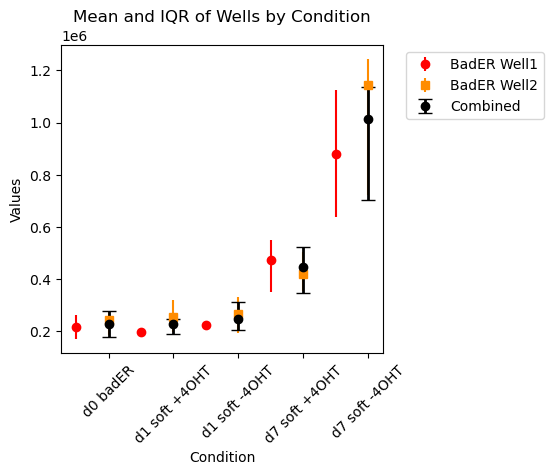

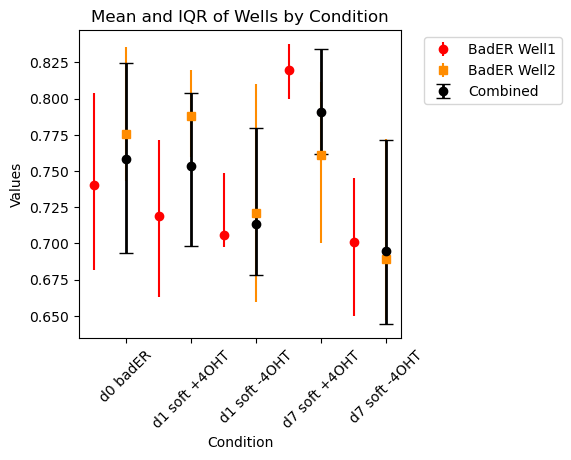

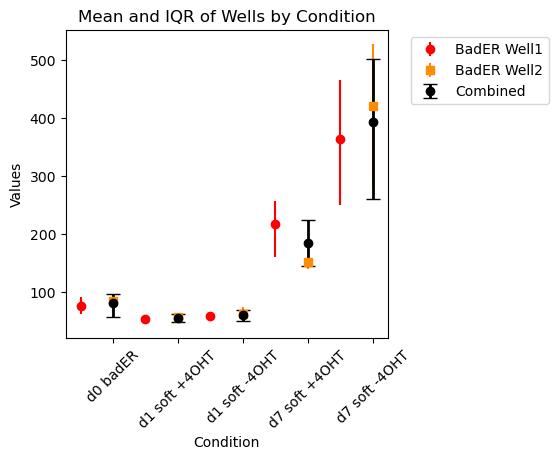

In [23]:
categories = ["vol", "roundness", "cell_no"]
for j, dataframe in enumerate([acinar_vol_df, acinar_round_df, acinar_cell_no_df]):
    abt_737_data, regular_data, bad_er_data, double_transfer_data = data_subcategories(dataframe)
    #titles = ["abt_737", "regular", "bad_er", "double_transfer"]
    titles=["bad_er"]
    for i, df in enumerate([bad_er_data]):
    #for i, df in enumerate([abt_737_data, regular_data, bad_er_data, double_transfer_data]):
        plot_and_save(df, "{}, {}".format(categories[j], titles[i]), "pdf")